In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import wordnet
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.tag import pos_tag
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from tqdm import tqdm_notebook
from tqdm import tqdm
tqdm.pandas(desc="my bar!")
from functions import *

//anaconda3/envs/metis/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
//anaconda3/envs/metis/lib/python3.7/site-packages/tqdm/std.py:651: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


`df['comment_text'] = df['comment_text'].astype(str)`

def class_labels(column):
    """
    Takes in target column and creates list of binary values. 1 (>=0.5) being in the 
    positive class (toxic), 0 (<0.5) being in the negative class (Not toxic)
    """
    class_label = []
    
    for row in column:
        
        if row < 0.5:
            class_label.append(0)
        else:
            class_label.append(1)
            
    return class_label

df['class'] = class_labels(df['target'])

In [36]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/luken2/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [75]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /Users/luken2/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [2]:
df = pd.read_csv('/Users/luken2/Documents/GitHub/toxicity/data/train.csv')

In [3]:
df = df[['target', 'comment_text']]

In [4]:
df['class'] = class_labels(df['target'])

In [5]:
clean_text(df, 'comment_text')

,target,comment_text,class
0,0.000000,this is so cool it's like 'would you want your...,0
1,0.000000,thank you!! this would make my life a lot less...,0
2,0.000000,this is such an urgent design problem kudos to...,0
3,0.000000,is this something i'll be able to install on m...,0
4,0.893617,haha you guys are a bunch of losers,1
...,...,...,...
1804869,0.000000,"maybe the tax on ""things"" would be collected w...",0
1804870,0.000000,what do you call people who still think the di...,0
1804871,0.000000,thank you right or wrong i am following your a...,0
1804872,0.621212,anyone who is quoted as having the following e...,1


In [3]:
df

,class,lemmatized
0,0,"[cool, like, want, mother, read, really, great..."
1,0,"[thank, make, life, lot, anxietyinducing, let,..."
2,0,"[urgent, design, problem, kudos, take, impress..."
3,0,"[able, install, site, release]"
4,1,"[haha, guy, bunch, loser]"
...,...,...
1804869,0,"[maybe, tax, thing, collect, product, import, ..."
1804870,0,"[people, think, divine, role, creation]"
1804871,0,"[thank, right, wrong, follow, advice]"
1804872,1,"[quote, have, follow, exchange, apocryphal, re..."


In [66]:
df['comment_text'] = df['comment_text'].astype(str)

In [86]:
df = df[['target','comment_text', 'class', 'tokens', 'no_stopwords']]

In [69]:
tokenizer = RegexpTokenizer(r'\w+\'*[a-zA-Z]+')
df['tokens'] = df['comment_text'].apply(tokenizer.tokenize)

In [71]:
stopwords = ["ain't", "aren't", "can't", "can't've", "'cause", "could've", "couldn't", "couldn't've", "didn't", "doesn't", "don't", "hadn't", "hadn't've", "hasn't", "haven't", "he'd", "he'd've", "he'll", "he'll've", "he's", "how'd", "how'd'y", "how'll", "how's", "i'd", "i'd've", "i'll", "i'll've", "i'm", "i've", "isn't", "it'd", "it'd've", "it'll", "it'll've", "it's", "let's", "ma'am", "mayn't", "might've", "mightn't", "mightn't've", "must've", "mustn't", "mustn't've", "needn't", "needn't've", "o'clock", "oughtn't", "oughtn't've", "shan't", "sha'n't", "shan't've", "she'd", "she'd've", "she'll", "she'll've", "she's", "should've", "shouldn't", "shouldn't've", "so've", "so's", "that'd", "that'd've", "that's", "there'd", "there'd've", "there's", "they'd", "they'd've", "they'll", "they'll've", "they're", "they've", "to've", "wasn't", "we'd", "we'd've", "we'll", "we'll've", "we're", "we've", "weren't", "what'll", "what'll've", "what're", "what's", "what've", "when's", "when've", "where'd", "where's", "where've", "who'll", "who'll've", "who's", "who've", "why's", "why've", "will've", "won't", "won't've", "would've", "wouldn't", "wouldn't've", "y'all", "y'all'd", "y'all'd've", "y'all're", "y'all've", "you'd", "you'd've", "you'll", "you'll've", "you're", "you've", "a", "about", "above", "above", "across", "after", "afterwards", "again", "against", "all", "almost", "alone", "along", "already", "also","although","always","am","among", "amongst", "amoungst", "amount",  "an", "and", "another", "any","anyhow","anyone","anything","anyway", "anywhere", "are", "around", "as",  "at", "back","be","became", "because","become","becomes", "becoming", "been", "before", "beforehand", "behind", "being", "below", "beside", "besides", "between", "beyond", "bill", "both", "bottom","but", "by", "call", "can", "cannot", "cant", "co", "con", "could", "couldnt", "cry", "de", "describe", "detail", "do", "done", "down", "due", "during", "each", "eg", "eight", "either", "eleven","else", "elsewhere", "empty", "enough", "etc", "even", "ever", "every", "everyone", "everything", "everywhere", "except", "few", "fifteen", "fify", "fill", "find", "fire", "first", "five", "for", "former", "formerly", "forty", "found", "four", "from", "front", "full", "further", "get", "give", "go", "had", "has", "hasnt", "have", "he", "hence", "her", "here", "hereafter", "hereby", "herein", "hereupon", "hers", "herself", "him", "himself", "his", "how", "however", "hundred", "ie", "if", "in", "inc", "indeed", "interest", "into", "is", "it", "its", "itself", "keep", "last", "latter", "latterly", "least", "less", "ltd", "made", "many", "may", "me", "meanwhile", "might", "mill", "mine", "more", "moreover", "most", "mostly", "move", "much", "must", "my", "myself", "name", "namely", "neither", "never", "nevertheless", "next", "nine", "no", "nobody", "none", "noone", "nor", "not", "nothing", "now", "nowhere", "of", "off", "often", "on", "once", "one", "only", "onto", "or", "other", "others", "otherwise", "our", "ours", "ourselves", "out", "over", "own","part", "per", "perhaps", "please", "put", "rather", "re", "same", "see", "seem", "seemed", "seeming", "seems", "serious", "several", "she", "should", "show", "side", "since", "sincere", "six", "sixty", "so", "some", "somehow", "someone", "something", "sometime", "sometimes", "somewhere", "still", "such", "system", "take", "ten", "than", "that", "the", "their", "them", "themselves", "then", "thence", "there", "thereafter", "thereby", "therefore", "therein", "thereupon", "these", "they", "thick", "thin", "third", "this", "those", "though", "three", "through", "throughout", "thru", "thus", "to", "together", "too", "top", "toward", "towards", "twelve", "twenty", "two", "un", "under", "until", "up", "upon", "us", "very", "via", "was", "we", "well", "were", "what", "whatever", "when", "whence", "whenever", "where", "whereafter", "whereas", "whereby", "wherein", "whereupon", "wherever", "whether", "which", "while", "whither", "who", "whoever", "whole", "whom", "whose", "why", "will", "with", "within", "without", "would", "yet", "you", "your", "yours", "yourself", "yourselves", "the"]
df['no_stopwords'] = df['tokens'].apply(lambda x: [(item for item in x if item not in stopwords)])


In [12]:
df['speech_tags'] = df['no_stopwords'].progress_apply(pos_tag)

my bar!: 100%|██████████| 1804874/1804874 [38:51<00:00, 774.12it/s] 


In [16]:
df['wordnet_pos'] = df['speech_tags'].progress_apply(lambda x: [(word, wordnet_pos(pos_tag)) for (word, pos_tag) in x])


my bar!:  37%|███▋      | 659656/1804874 [00:34<00:38, 30103.58it/s]


my bar!:  76%|███████▌  | 1370543/1804874 [01:20<06:59, 1035.85it/s]


my bar!: 100%|██████████| 1804874/1804874 [01:34<00:00, 19193.08it/s]


In [15]:
def wordnet_pos(tag):
    from nltk.corpus import wordnet
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [19]:
lemmatizer = WordNetLemmatizer()

In [20]:
df['lemmatized'] = df['wordnet_pos'].progress_apply(lambda x: [lemmatizer.lemmatize(word, tag) for (word, tag) in x])



my bar!:   0%|          | 0/1804874 [00:00<?, ?it/s]

my bar!:   0%|          | 59/1804874 [00:00<52:09, 576.79it/s]

my bar!:   0%|          | 282/1804874 [00:00<40:32, 741.73it/s]

my bar!:   0%|          | 808/1804874 [00:00<30:05, 999.17it/s]

my bar!:   0%|          | 1461/1804874 [00:00<22:26, 1339.51it/s]

my bar!:   0%|          | 1982/1804874 [00:00<17:26, 1723.38it/s]

my bar!:   0%|          | 2558/1804874 [00:00<13:46, 2181.97it/s]

my bar!:   0%|          | 3172/1804874 [00:00<11:06, 2704.10it/s]

my bar!:   0%|          | 3850/1804874 [00:00<09:06, 3298.42it/s]

my bar!:   0%|          | 4552/1804874 [00:00<07:39, 3921.28it/s]

my bar!:   0%|          | 5215/1804874 [00:01<06:42, 4468.23it/s]

my bar!:   0%|          | 5832/1804874 [00:01<06:12, 4826.76it/s]

my bar!:   0%|          | 6499/1804874 [00:01<05:42, 5253.02it/s]

my bar!:   0%|          | 7125/1804874 [00:01<05:38, 5309.61it/s]

my bar!:   0%|          | 7727/1804874 [00:01<05:32, 5403.17it/s]

my bar!:   0%

my bar!:  11%|█         | 199886/1804874 [00:22<02:58, 8971.44it/s]

my bar!:  11%|█         | 200799/1804874 [00:22<02:58, 9010.09it/s]

my bar!:  11%|█         | 201728/1804874 [00:22<02:56, 9086.51it/s]

my bar!:  11%|█         | 202648/1804874 [00:22<02:55, 9119.18it/s]

my bar!:  11%|█▏        | 203561/1804874 [00:23<02:57, 9025.59it/s]

my bar!:  11%|█▏        | 204465/1804874 [00:23<03:01, 8806.77it/s]

my bar!:  11%|█▏        | 205348/1804874 [00:23<03:01, 8797.21it/s]

my bar!:  11%|█▏        | 206268/1804874 [00:23<02:59, 8913.85it/s]

my bar!:  11%|█▏        | 207161/1804874 [00:23<02:59, 8895.66it/s]

my bar!:  12%|█▏        | 208052/1804874 [00:23<03:07, 8515.65it/s]

my bar!:  12%|█▏        | 209045/1804874 [00:23<02:59, 8893.02it/s]

my bar!:  12%|█▏        | 209942/1804874 [00:23<02:59, 8884.10it/s]

my bar!:  12%|█▏        | 210956/1804874 [00:23<02:52, 9226.44it/s]

my bar!:  12%|█▏        | 211886/1804874 [00:24<02:55, 9086.33it/s]

my bar!:  12%|█▏        | 212800/1

my bar!:  23%|██▎       | 411129/1804874 [00:45<02:22, 9770.44it/s]

my bar!:  23%|██▎       | 412155/1804874 [00:45<02:20, 9911.80it/s]

my bar!:  23%|██▎       | 413148/1804874 [00:45<02:20, 9915.94it/s]

my bar!:  23%|██▎       | 414276/1804874 [00:45<02:15, 10286.76it/s]

my bar!:  23%|██▎       | 415310/1804874 [00:45<02:18, 10031.90it/s]

my bar!:  23%|██▎       | 416318/1804874 [00:45<02:19, 9976.90it/s] 

my bar!:  23%|██▎       | 417450/1804874 [00:45<02:14, 10343.68it/s]

my bar!:  23%|██▎       | 418491/1804874 [00:45<02:22, 9716.64it/s] 

my bar!:  23%|██▎       | 419475/1804874 [00:46<02:25, 9515.61it/s]

my bar!:  23%|██▎       | 420436/1804874 [00:46<02:26, 9444.10it/s]

my bar!:  23%|██▎       | 421387/1804874 [00:46<02:29, 9267.74it/s]

my bar!:  23%|██▎       | 422320/1804874 [00:46<02:31, 9096.84it/s]

my bar!:  23%|██▎       | 423235/1804874 [00:46<02:36, 8821.43it/s]

my bar!:  24%|██▎       | 424197/1804874 [00:46<02:32, 9046.24it/s]

my bar!:  24%|██▎       | 425

my bar!:  35%|███▍      | 622978/1804874 [01:07<02:16, 8653.56it/s]

my bar!:  35%|███▍      | 623846/1804874 [01:07<02:19, 8453.81it/s]

my bar!:  35%|███▍      | 624790/1804874 [01:07<02:15, 8723.17it/s]

my bar!:  35%|███▍      | 625670/1804874 [01:07<02:14, 8746.05it/s]

my bar!:  35%|███▍      | 626597/1804874 [01:07<02:12, 8895.86it/s]

my bar!:  35%|███▍      | 627586/1804874 [01:08<02:08, 9171.96it/s]

my bar!:  35%|███▍      | 628508/1804874 [01:08<02:10, 9045.69it/s]

my bar!:  35%|███▍      | 629416/1804874 [01:08<02:12, 8861.27it/s]

my bar!:  35%|███▍      | 630306/1804874 [01:08<02:17, 8550.10it/s]

my bar!:  35%|███▍      | 631166/1804874 [01:08<02:19, 8394.51it/s]

my bar!:  35%|███▌      | 632104/1804874 [01:08<02:15, 8665.73it/s]

my bar!:  35%|███▌      | 632976/1804874 [01:08<02:15, 8658.85it/s]

my bar!:  35%|███▌      | 633846/1804874 [01:08<02:17, 8534.50it/s]

my bar!:  35%|███▌      | 634703/1804874 [01:08<02:17, 8502.62it/s]

my bar!:  35%|███▌      | 635598/1

my bar!:  46%|████▌     | 834051/1804874 [01:29<01:41, 9589.76it/s]

my bar!:  46%|████▋     | 835014/1804874 [01:30<01:42, 9448.19it/s]

my bar!:  46%|████▋     | 835979/1804874 [01:30<01:41, 9502.36it/s]

my bar!:  46%|████▋     | 836932/1804874 [01:30<01:41, 9501.28it/s]

my bar!:  46%|████▋     | 837884/1804874 [01:30<01:44, 9270.11it/s]

my bar!:  46%|████▋     | 838814/1804874 [01:30<01:49, 8833.15it/s]

my bar!:  47%|████▋     | 839793/1804874 [01:30<01:46, 9098.45it/s]

my bar!:  47%|████▋     | 840874/1804874 [01:30<01:40, 9552.14it/s]

my bar!:  47%|████▋     | 841840/1804874 [01:30<01:41, 9522.40it/s]

my bar!:  47%|████▋     | 842800/1804874 [01:30<01:41, 9486.97it/s]

my bar!:  47%|████▋     | 843758/1804874 [01:31<01:41, 9514.63it/s]

my bar!:  47%|████▋     | 844714/1804874 [01:31<01:41, 9465.28it/s]

my bar!:  47%|████▋     | 845664/1804874 [01:31<01:41, 9408.84it/s]

my bar!:  47%|████▋     | 846607/1804874 [01:31<01:45, 9060.18it/s]

my bar!:  47%|████▋     | 847561/1

my bar!:  58%|█████▊    | 1045928/1804874 [01:52<01:18, 9635.67it/s]

my bar!:  58%|█████▊    | 1046901/1804874 [01:52<01:18, 9662.62it/s]

my bar!:  58%|█████▊    | 1047870/1804874 [01:52<01:19, 9498.55it/s]

my bar!:  58%|█████▊    | 1048823/1804874 [01:52<01:19, 9488.54it/s]

my bar!:  58%|█████▊    | 1049793/1804874 [01:52<01:19, 9548.74it/s]

my bar!:  58%|█████▊    | 1050750/1804874 [01:52<01:18, 9554.59it/s]

my bar!:  58%|█████▊    | 1051762/1804874 [01:52<01:17, 9712.41it/s]

my bar!:  58%|█████▊    | 1052761/1804874 [01:53<01:16, 9789.76it/s]

my bar!:  58%|█████▊    | 1053741/1804874 [01:53<01:16, 9757.75it/s]

my bar!:  58%|█████▊    | 1054793/1804874 [01:53<01:15, 9974.28it/s]

my bar!:  58%|█████▊    | 1055793/1804874 [01:53<01:16, 9783.15it/s]

my bar!:  59%|█████▊    | 1056774/1804874 [01:53<01:16, 9777.46it/s]

my bar!:  59%|█████▊    | 1057754/1804874 [01:53<01:17, 9609.85it/s]

my bar!:  59%|█████▊    | 1058717/1804874 [01:53<01:20, 9305.41it/s]

my bar!:  59%|█████▊

my bar!:  69%|██████▉   | 1252161/1804874 [02:14<01:08, 8116.43it/s]

my bar!:  69%|██████▉   | 1253046/1804874 [02:14<01:06, 8321.74it/s]

my bar!:  69%|██████▉   | 1253979/1804874 [02:14<01:04, 8600.54it/s]

my bar!:  70%|██████▉   | 1254875/1804874 [02:14<01:03, 8704.73it/s]

my bar!:  70%|██████▉   | 1255751/1804874 [02:14<01:03, 8680.56it/s]

my bar!:  70%|██████▉   | 1256733/1804874 [02:14<01:00, 8991.26it/s]

my bar!:  70%|██████▉   | 1257638/1804874 [02:15<01:01, 8894.69it/s]

my bar!:  70%|██████▉   | 1258532/1804874 [02:15<01:02, 8803.31it/s]

my bar!:  70%|██████▉   | 1259423/1804874 [02:15<01:01, 8834.66it/s]

my bar!:  70%|██████▉   | 1260405/1804874 [02:15<00:59, 9106.52it/s]

my bar!:  70%|██████▉   | 1261363/1804874 [02:15<00:58, 9243.07it/s]

my bar!:  70%|██████▉   | 1262321/1804874 [02:15<00:58, 9339.23it/s]

my bar!:  70%|██████▉   | 1263359/1804874 [02:15<00:56, 9628.30it/s]

my bar!:  70%|███████   | 1264326/1804874 [02:15<00:56, 9528.21it/s]

my bar!:  70%|██████

my bar!:  81%|████████  | 1457061/1804874 [03:53<00:39, 8893.51it/s]

my bar!:  81%|████████  | 1457957/1804874 [03:53<00:39, 8849.54it/s]

my bar!:  81%|████████  | 1458909/1804874 [03:53<00:38, 9038.70it/s]

my bar!:  81%|████████  | 1459817/1804874 [03:53<00:38, 8924.71it/s]

my bar!:  81%|████████  | 1460713/1804874 [03:53<00:38, 8910.28it/s]

my bar!:  81%|████████  | 1461700/1804874 [03:53<00:37, 9171.64it/s]

my bar!:  81%|████████  | 1462641/1804874 [03:53<00:37, 9241.11it/s]

my bar!:  81%|████████  | 1463568/1804874 [03:53<00:36, 9233.20it/s]

my bar!:  81%|████████  | 1464494/1804874 [03:53<00:37, 9063.30it/s]

my bar!:  81%|████████  | 1465500/1804874 [03:53<00:36, 9334.68it/s]

my bar!:  81%|████████  | 1466437/1804874 [03:54<00:36, 9311.84it/s]

my bar!:  81%|████████▏ | 1467374/1804874 [03:54<00:36, 9328.96it/s]

my bar!:  81%|████████▏ | 1468309/1804874 [03:54<00:36, 9297.76it/s]

my bar!:  81%|████████▏ | 1469240/1804874 [03:54<00:38, 8782.72it/s]

my bar!:  81%|██████

my bar!:  92%|█████████▏| 1657752/1804874 [04:16<00:22, 6455.29it/s]

my bar!:  92%|█████████▏| 1658621/1804874 [04:16<00:20, 6994.32it/s]

my bar!:  92%|█████████▏| 1659496/1804874 [04:16<00:19, 7440.51it/s]

my bar!:  92%|█████████▏| 1660403/1804874 [04:16<00:18, 7862.68it/s]

my bar!:  92%|█████████▏| 1661305/1804874 [04:16<00:17, 8177.22it/s]

my bar!:  92%|█████████▏| 1662282/1804874 [04:16<00:16, 8596.47it/s]

my bar!:  92%|█████████▏| 1663225/1804874 [04:16<00:16, 8823.67it/s]

my bar!:  92%|█████████▏| 1664132/1804874 [04:17<00:46, 3021.50it/s]

my bar!:  92%|█████████▏| 1665086/1804874 [04:17<00:36, 3799.97it/s]

my bar!:  92%|█████████▏| 1666028/1804874 [04:17<00:30, 4625.16it/s]

my bar!:  92%|█████████▏| 1666883/1804874 [04:17<00:25, 5362.65it/s]

my bar!:  92%|█████████▏| 1667707/1804874 [04:18<00:23, 5944.40it/s]

my bar!:  92%|█████████▏| 1668607/1804874 [04:18<00:20, 6617.66it/s]

my bar!:  92%|█████████▏| 1669448/1804874 [04:18<00:19, 6987.95it/s]

my bar!:  93%|██████

In [22]:
df.to_pickle('/Users/luken2/Documents/GitHub/toxicity/data/train_cleaned.pickle')

In [2]:
df = pd.read_pickle('/Users/luken2/Documents/GitHub/toxicity/data/text_class.pickle')

In [4]:
df[['class', 'lemmatized']].to_pickle('/Users/luken2/Documents/GitHub/toxicity/data/text_class.pickle')

In [3]:
df['class'].value_counts()

0    1660540
1     144334
Name: class, dtype: int64

In [4]:
words = [word for row in df['lemmatized'] for word in row]
vocab = list(set(words))
sentence_lengths = [len(sentence) for sentence in df['lemmatized']]
print('Total Words: ', len(words))
print('Unique Words: ', len(vocab))
print('Longest Sentence: ', max(sentence_lengths), 'words')

Total Words:  42157140
Unique Words:  588800
Longest Sentence:  304 words


In [1]:
X = df['lemmatized']
y = df['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

NameError: name 'df' is not defined

In [6]:
def tf_idf(text_tokens):
    """
    Gives text data in tokenized form to create bag of words
    with TfidfVectorizer.  Returns bag of words and vectorizer.
    """
    from sklearn.feature_extraction.text import TfidfVectorizer
    
    def dummy(doc):
        """
        Used since text data is already tokenized and preprocessed
        """
        return doc
    
    tf = TfidfVectorizer(tokenizer=dummy, preprocessor=dummy, token_pattern=None)
    
    bag = tf.fit_transform(text_tokens)
    
    return bag, tf

In [7]:
X_train, tf = tf_idf(X_train)
X_test = tf.transform(X_test)

In [10]:
def lsa(vectorized_words, dimensions):
    """
    Takes in embedded text and number of components 
    wanted dimensionality reduced to
    """
    from sklearn.decomposition import TruncatedSVD
 
    lsa = TruncatedSVD(n_components=dimensions)
    lsa.fit(vectorized_words)
    lsa_values = lsa.transform(vectorized_words)
    
    return lsa_values, lsa

In [11]:
X_train, lsa = lsa(X_train, 10)

In [12]:
X_test = lsa.transform(X_test)

In [49]:
def plot_lsa(vectorized_words, class_labels):
    """
    Plots embedded words in two dimensions with color based on class
    """
    from sklearn.decomposition import TruncatedSVD
    
    # We are using 2 dimensions for visualization
    lsa = TruncatedSVD(n_components=2)
    lsa.fit(vectorized_words)
    lsa_scores = lsa.transform(vectorized_words)
    
    plt.figure(figsize=(8, 8))
    plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=4, c=class_labels, alpha=0.5)
   
    plt.show()

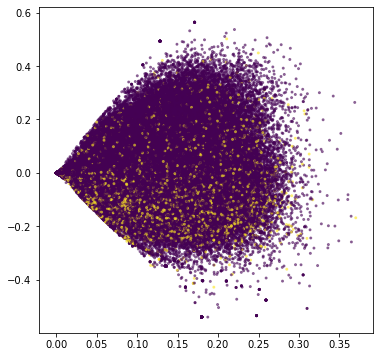

In [50]:
plot_lsa(X_train, y_train)

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

In [14]:
clf = LogisticRegression(C=30, solver='newton-cg', n_jobs=-1, random_state=42)
clf.fit(X_train, y_train)

LogisticRegression(C=30, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=-1, penalty='l2', random_state=42,
                   solver='newton-cg', tol=0.0001, verbose=0, warm_start=False)

In [15]:
def evaluate_model(y_true, y_predicted):
    """
    Evaluates performance of model by taking in true and predicted
    y labels and returning accuracy, f1score, presicion and recall
    """
    accuracy = accuracy_score(y_true, y_predicted)
    
    precision = precision_score(y_true, y_predicted)
    
    recall = recall_score(y_true, y_predicted)
    
    f1 = f1_score(y_true, y_predicted)
    
    print('Accuracy: ', accuracy)
    print('Precision: ', precision)
    print('Recall: ', recall)
    print('f1_score: ', f1)
    

In [16]:
evaluate_model(y_test, clf.predict(X_test))

Accuracy:  0.9192631068633562
Precision:  0.041666666666666664
Recall:  0.00010317078203452782
f1_score:  0.0002058319039451115


In [17]:
confusion_matrix(y_test, clf.predict(X_test))

array([[331828,     69],
       [ 29075,      3]])

In [16]:
def plot_all_dimensions(data, class_labels, title=""):
    plt.rcParams['figure.figsize'] = [30, 20]
    
    dims = data.shape[1]
    assert dims <= 6
    
    count = 1
    for dim in range(dims):
        i = dim
        j = (i+1) * int(dim != dims-1)
        
        plt.subplot(2,3, count)
        plt.scatter(data[:,i], data[:,j],# ckbk_space[vect][dr][:,2],
                   s = 4, alpha = 0.5, c=class_labels)
        plt.title(title, fontsize=20, color='red')
        count += 1
    plt.show()

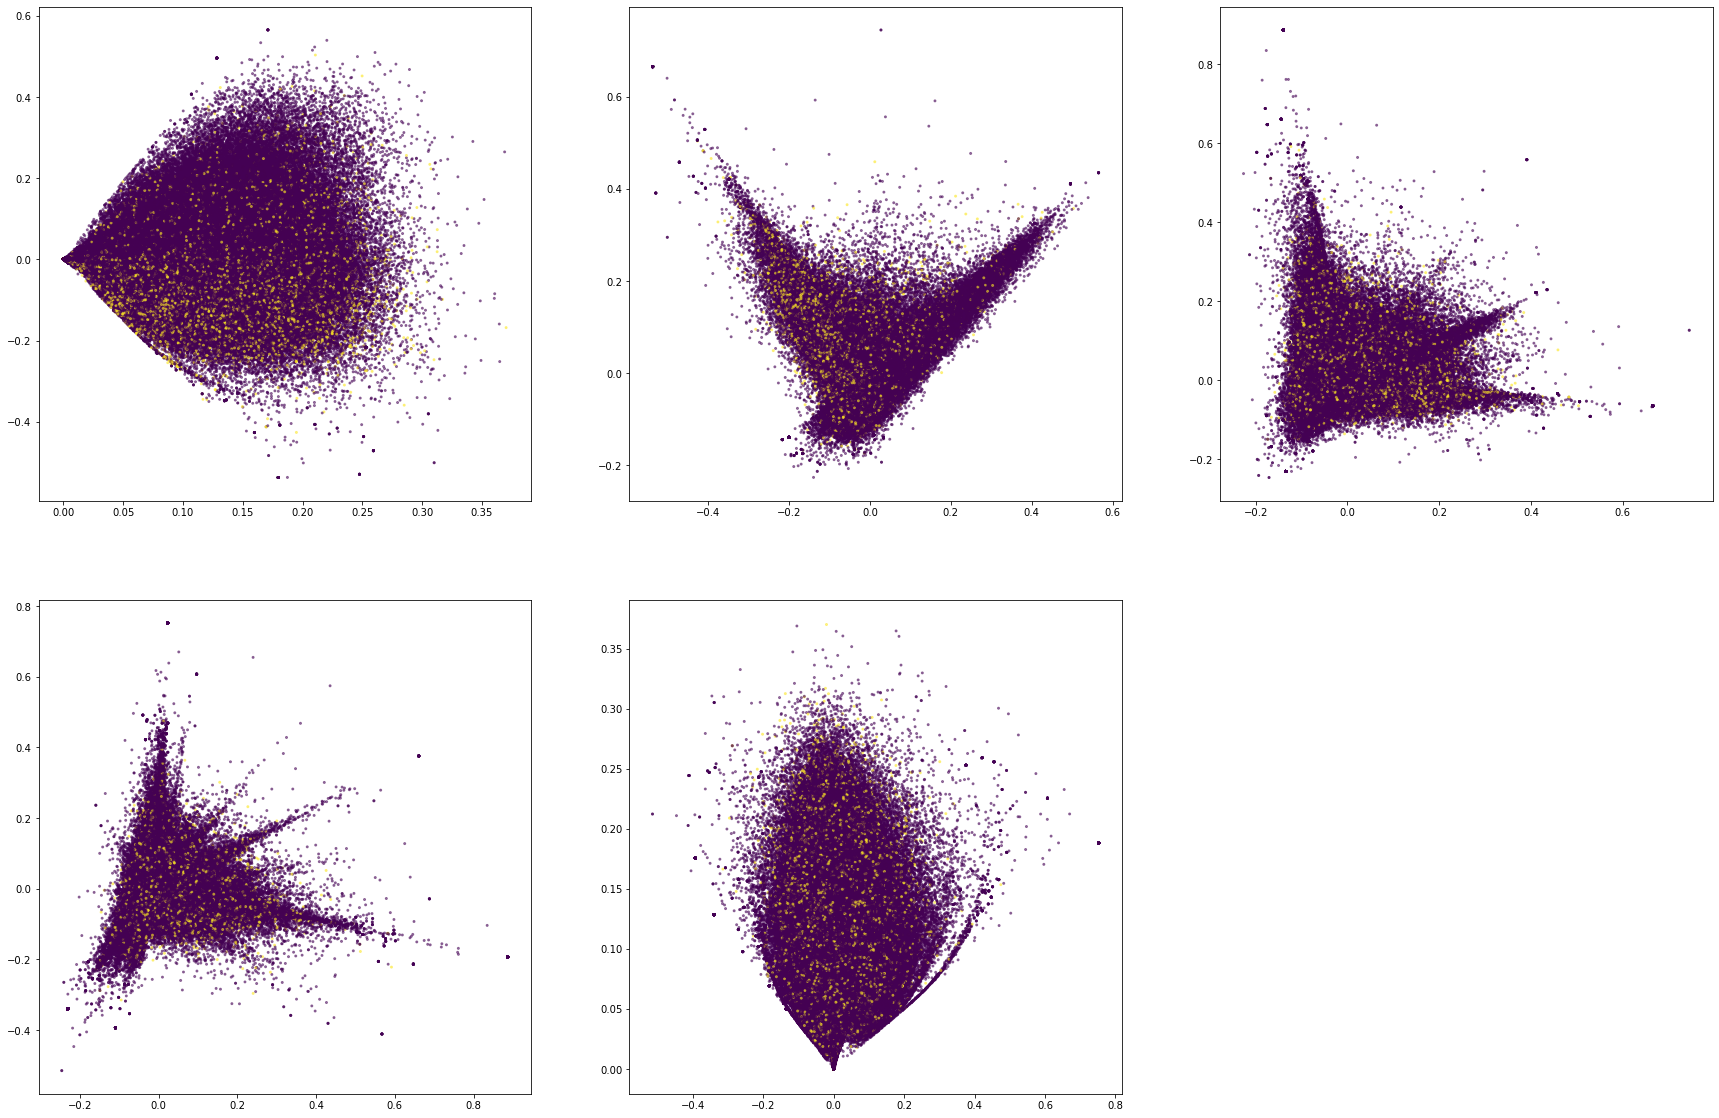

In [17]:
plot_all_dimensions(X_train, y_train)